# 1-4,时间序列数据建模流程范例

国内的新冠肺炎疫情从发现至今已经持续3个多月了，这场起源于吃野味的灾难给大家的生活造成了诸多方面的影响。

有的同学是收入上的，有的同学是感情上的，有的同学是心理上的，还有的同学是体重上的。

那么国内的新冠肺炎疫情何时结束呢？什么时候我们才可以重获自由呢？

本篇文章将利用TensorFlow2.0建立时间序列RNN模型，对国内的新冠肺炎疫情结束时间进行预测。

![](./data/疫情前后对比.png)

### 一，准备数据



本文的数据集取自tushare，获取该数据集的方法参考了以下文章。

《https://zhuanlan.zhihu.com/p/109556102》

![](./data/1-4-新增人数.png)


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks 


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text major ticklabel objects>)

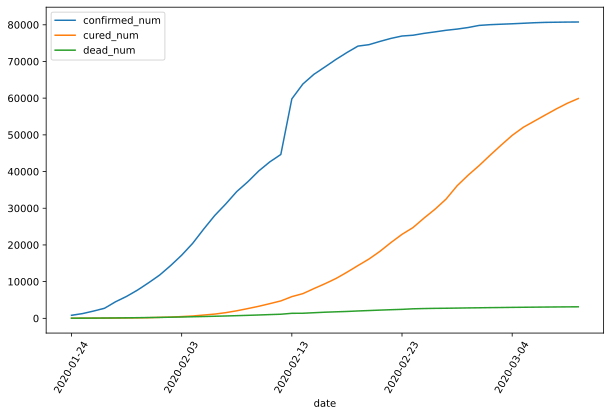

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)


![](./data/1-4-累积曲线.png)

array([[4.5700e+02, 4.0000e+00, 1.6000e+01],
       [6.8800e+02, 1.1000e+01, 1.5000e+01],
       [7.6900e+02, 2.0000e+00, 2.4000e+01],
       [1.7710e+03, 9.0000e+00, 2.6000e+01],
       [1.4590e+03, 4.3000e+01, 2.6000e+01],
       [1.7370e+03, 2.1000e+01, 3.8000e+01],
       [1.9810e+03, 4.7000e+01, 4.3000e+01],
       [2.0990e+03, 8.8000e+01, 3.0000e+01],
       [2.5890e+03, 6.9000e+01, 6.1000e+01],
       [2.8250e+03, 1.4700e+02, 5.7000e+01],
       [3.2330e+03, 1.5700e+02, 6.4000e+01],
       [3.8860e+03, 2.6000e+02, 6.5000e+01],
       [3.6940e+03, 2.6100e+02, 7.3000e+01],
       [3.1430e+03, 3.8700e+02, 7.3000e+01],
       [3.3850e+03, 5.1000e+02, 8.6000e+01],
       [2.6520e+03, 5.9900e+02, 8.9000e+01],
       [2.9730e+03, 6.3200e+02, 9.7000e+01],
       [2.4670e+03, 7.1500e+02, 1.0800e+02],
       [2.0150e+03, 7.4400e+02, 9.7000e+01],
       [1.5151e+04, 1.1710e+03, 2.5400e+02],
       [4.0470e+03, 8.1200e+02, 1.3000e+01],
       [2.6410e+03, 1.3730e+03, 1.4300e+02],
       [2.

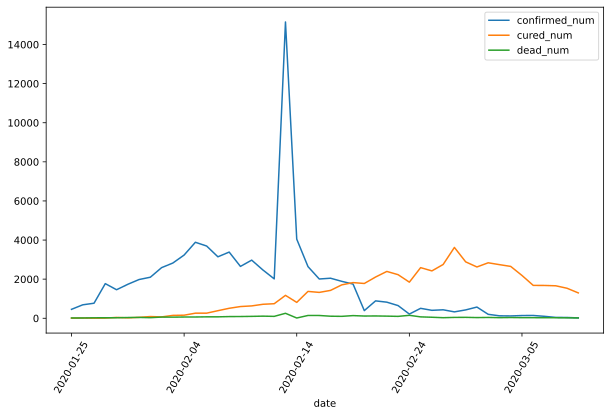

In [10]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")
dfdiff.values

![](./data/1-4-新增曲线.png)

In [20]:
#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()



In [21]:
for i in ds_train.unbatch().take(4):
    print(i)

(<tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[4.570e+02, 4.000e+00, 1.600e+01],
       [6.880e+02, 1.100e+01, 1.500e+01],
       [7.690e+02, 2.000e+00, 2.400e+01],
       [1.771e+03, 9.000e+00, 2.600e+01],
       [1.459e+03, 4.300e+01, 2.600e+01],
       [1.737e+03, 2.100e+01, 3.800e+01],
       [1.981e+03, 4.700e+01, 4.300e+01],
       [2.099e+03, 8.800e+01, 3.000e+01]], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([2589.,   69.,   61.], dtype=float32)>)
(<tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[6.880e+02, 1.100e+01, 1.500e+01],
       [7.690e+02, 2.000e+00, 2.400e+01],
       [1.771e+03, 9.000e+00, 2.600e+01],
       [1.459e+03, 4.300e+01, 2.600e+01],
       [1.737e+03, 2.100e+01, 3.800e+01],
       [1.981e+03, 4.700e+01, 4.300e+01],
       [2.099e+03, 8.800e+01, 3.000e+01],
       [2.589e+03, 6.900e+01, 6.100e+01]], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([2825.,  147.,   57.], dtype=float32)>)
(<tf.Tensor:

### 二，定义模型

使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用函数式API构建任意结构模型。

In [24]:
#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config


In [25]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

```
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0         
=================================================================
Total params: 348
Trainable params: 348
Non-trainable params: 0
_________________________________________________________________
```

### 三，训练模型

训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。

In [26]:
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config


In [27]:
import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)


Epoch 1/500
1/1 [==============================] - 9s 9s/step - loss: 3.3586
Epoch 2/500
1/1 [==============================] - 0s 78ms/step - loss: 3.1732
Epoch 3/500
1/1 [==============================] - 0s 51ms/step - loss: 2.9817
Epoch 4/500
1/1 [==============================] - 0s 134ms/step - loss: 2.7802
Epoch 5/500
1/1 [==============================] - 0s 171ms/step - loss: 2.5680
Epoch 6/500
1/1 [==============================] - 0s 122ms/step - loss: 2.3456
Epoch 7/500
1/1 [==============================] - 0s 227ms/step - loss: 2.1144
Epoch 8/500
1/1 [==============================] - 0s 80ms/step - loss: 1.8776
Epoch 9/500
1/1 [==============================] - 0s 61ms/step - loss: 1.6406
Epoch 10/500
1/1 [==============================] - 0s 97ms/step - loss: 1.4116
Epoch 11/500
1/1 [==============================] - 0s 101ms/step - loss: 1.2023
Epoch 12/500
1/1 [==============================] - 0s 92ms/step - loss: 1.0282
Epoch 13/500
1/1 [============================

Epoch 104/500
1/1 [==============================] - 0s 97ms/step - loss: 0.2779
Epoch 105/500
1/1 [==============================] - 0s 147ms/step - loss: 0.2778
Epoch 106/500
1/1 [==============================] - 0s 101ms/step - loss: 0.2777
Epoch 107/500
1/1 [==============================] - 0s 113ms/step - loss: 0.2776
Epoch 108/500
1/1 [==============================] - 0s 118ms/step - loss: 0.2775
Epoch 109/500
1/1 [==============================] - 0s 120ms/step - loss: 0.2775
Epoch 110/500
1/1 [==============================] - 0s 146ms/step - loss: 0.2774
Epoch 111/500
1/1 [==============================] - 0s 114ms/step - loss: 0.2773
Epoch 112/500
1/1 [==============================] - 0s 119ms/step - loss: 0.2772
Epoch 113/500
1/1 [==============================] - 0s 113ms/step - loss: 0.2771
Epoch 114/500
1/1 [==============================] - 0s 67ms/step - loss: 0.2770
Epoch 115/500
1/1 [==============================] - 0s 60ms/step - loss: 0.2770
Epoch 116/500
1/1 [

Epoch 205/500
1/1 [==============================] - 0s 64ms/step - loss: 0.2728
Epoch 206/500
1/1 [==============================] - 0s 54ms/step - loss: 0.2728
Epoch 207/500
1/1 [==============================] - 0s 71ms/step - loss: 0.2727
Epoch 208/500
1/1 [==============================] - 0s 71ms/step - loss: 0.2727
Epoch 209/500
1/1 [==============================] - 0s 50ms/step - loss: 0.2727
Epoch 210/500
1/1 [==============================] - 0s 57ms/step - loss: 0.2726
Epoch 211/500
1/1 [==============================] - 0s 55ms/step - loss: 0.2726
Epoch 212/500
1/1 [==============================] - 0s 56ms/step - loss: 0.2726
Epoch 213/500
1/1 [==============================] - 0s 55ms/step - loss: 0.2726
Epoch 214/500
1/1 [==============================] - 0s 96ms/step - loss: 0.2725
Epoch 215/500
1/1 [==============================] - 0s 80ms/step - loss: 0.2725
Epoch 216/500
1/1 [==============================] - 0s 171ms/step - loss: 0.2725
Epoch 217/500
1/1 [========

Epoch 306/500
1/1 [==============================] - 0s 78ms/step - loss: 0.2701
Epoch 307/500
1/1 [==============================] - 0s 68ms/step - loss: 0.2700
Epoch 308/500
1/1 [==============================] - 0s 52ms/step - loss: 0.2700
Epoch 309/500
1/1 [==============================] - 0s 61ms/step - loss: 0.2700
Epoch 310/500
1/1 [==============================] - 0s 78ms/step - loss: 0.2700
Epoch 311/500
1/1 [==============================] - 0s 75ms/step - loss: 0.2699
Epoch 312/500
1/1 [==============================] - 0s 122ms/step - loss: 0.2699
Epoch 313/500
1/1 [==============================] - 0s 88ms/step - loss: 0.2699
Epoch 314/500
1/1 [==============================] - 0s 70ms/step - loss: 0.2699
Epoch 315/500
1/1 [==============================] - 0s 60ms/step - loss: 0.2698
Epoch 316/500
1/1 [==============================] - 0s 52ms/step - loss: 0.2698
Epoch 317/500
1/1 [==============================] - 0s 70ms/step - loss: 0.2698
Epoch 318/500
1/1 [========

Epoch 407/500
1/1 [==============================] - 0s 87ms/step - loss: 0.2676
Epoch 408/500
1/1 [==============================] - 0s 103ms/step - loss: 0.2676
Epoch 409/500
1/1 [==============================] - 0s 95ms/step - loss: 0.2675
Epoch 410/500
1/1 [==============================] - 0s 83ms/step - loss: 0.2675
Epoch 411/500
1/1 [==============================] - 0s 75ms/step - loss: 0.2675
Epoch 412/500
1/1 [==============================] - 0s 101ms/step - loss: 0.2675
Epoch 413/500
1/1 [==============================] - 0s 78ms/step - loss: 0.2674
Epoch 414/500
1/1 [==============================] - 0s 89ms/step - loss: 0.2674
Epoch 415/500
1/1 [==============================] - 0s 81ms/step - loss: 0.2674
Epoch 416/500
1/1 [==============================] - 0s 82ms/step - loss: 0.2674
Epoch 417/500
1/1 [==============================] - 0s 96ms/step - loss: 0.2674
Epoch 418/500
1/1 [==============================] - 0s 82ms/step - loss: 0.2673
Epoch 419/500
1/1 [=======

```
Epoch 371/500
1/1 [==============================] - 0s 61ms/step - loss: 0.1184
Epoch 372/500
1/1 [==============================] - 0s 64ms/step - loss: 0.1177
Epoch 373/500
1/1 [==============================] - 0s 56ms/step - loss: 0.1169
Epoch 374/500
1/1 [==============================] - 0s 50ms/step - loss: 0.1161
Epoch 375/500
1/1 [==============================] - 0s 55ms/step - loss: 0.1154
Epoch 376/500
1/1 [==============================] - 0s 55ms/step - loss: 0.1147
Epoch 377/500
1/1 [==============================] - 0s 62ms/step - loss: 0.1140
Epoch 378/500
1/1 [==============================] - 0s 93ms/step - loss: 0.1133
Epoch 379/500
1/1 [==============================] - 0s 85ms/step - loss: 0.1126
Epoch 380/500
1/1 [==============================] - 0s 68ms/step - loss: 0.1119
Epoch 381/500
1/1 [==============================] - 0s 52ms/step - loss: 0.1113
Epoch 382/500
1/1 [==============================] - 0s 54ms/step - loss: 0.1107
Epoch 383/500
1/1 [==============================] - 0s 55ms/step - loss: 0.1100
Epoch 384/500
1/1 [==============================] - 0s 56ms/step - loss: 0.1094
Epoch 385/500
1/1 [==============================] - 0s 54ms/step - loss: 0.1088
Epoch 386/500
1/1 [==============================] - 0s 74ms/step - loss: 0.1082
Epoch 387/500
1/1 [==============================] - 0s 60ms/step - loss: 0.1077
Epoch 388/500
1/1 [==============================] - 0s 52ms/step - loss: 0.1071
Epoch 389/500
1/1 [==============================] - 0s 52ms/step - loss: 0.1066
Epoch 390/500
1/1 [==============================] - 0s 56ms/step - loss: 0.1060
Epoch 391/500
1/1 [==============================] - 0s 61ms/step - loss: 0.1055
Epoch 392/500
1/1 [==============================] - 0s 60ms/step - loss: 0.1050
Epoch 393/500
1/1 [==============================] - 0s 59ms/step - loss: 0.1045
Epoch 394/500
1/1 [==============================] - 0s 65ms/step - loss: 0.1040
Epoch 395/500
1/1 [==============================] - 0s 58ms/step - loss: 0.1035
Epoch 396/500
1/1 [==============================] - 0s 52ms/step - loss: 0.1031
Epoch 397/500
1/1 [==============================] - 0s 58ms/step - loss: 0.1026
Epoch 398/500
1/1 [==============================] - 0s 60ms/step - loss: 0.1022
Epoch 399/500
1/1 [==============================] - 0s 57ms/step - loss: 0.1017
Epoch 400/500
1/1 [==============================] - 0s 63ms/step - loss: 0.1013
Epoch 401/500
1/1 [==============================] - 0s 59ms/step - loss: 0.1009
Epoch 402/500
1/1 [==============================] - 0s 53ms/step - loss: 0.1005
Epoch 403/500
1/1 [==============================] - 0s 56ms/step - loss: 0.1001
Epoch 404/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0997
Epoch 405/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0993
Epoch 406/500
1/1 [==============================] - 0s 53ms/step - loss: 0.0990
Epoch 407/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0986
Epoch 408/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0982
Epoch 409/500
1/1 [==============================] - 0s 67ms/step - loss: 0.0979
Epoch 410/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0976
Epoch 411/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0972
Epoch 412/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0969
Epoch 413/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0966
Epoch 414/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0963
Epoch 415/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0960
Epoch 416/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0957
Epoch 417/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0954
Epoch 418/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0951
Epoch 419/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0948
Epoch 420/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0946
Epoch 421/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0943
Epoch 422/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0941
Epoch 423/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0938
Epoch 424/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0936
Epoch 425/500
1/1 [==============================] - 0s 100ms/step - loss: 0.0933
Epoch 426/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0931
Epoch 427/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0929
Epoch 428/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0926
Epoch 429/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0924
Epoch 430/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0922
Epoch 431/500
1/1 [==============================] - 0s 75ms/step - loss: 0.0920
Epoch 432/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0918
Epoch 433/500
1/1 [==============================] - 0s 77ms/step - loss: 0.0916
Epoch 434/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0914
Epoch 435/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0912
Epoch 436/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0911
Epoch 437/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0909
Epoch 438/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0907
Epoch 439/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0905
Epoch 440/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0904
Epoch 441/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0902
Epoch 442/500
1/1 [==============================] - 0s 73ms/step - loss: 0.0901
Epoch 443/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0899
Epoch 444/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0898
Epoch 445/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0896
Epoch 446/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0895
Epoch 447/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0893
Epoch 448/500
1/1 [==============================] - 0s 64ms/step - loss: 0.0892
Epoch 449/500
1/1 [==============================] - 0s 70ms/step - loss: 0.0891
Epoch 450/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0889
Epoch 451/500
1/1 [==============================] - 0s 53ms/step - loss: 0.0888
Epoch 452/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0887
Epoch 453/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0886
Epoch 454/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0885
Epoch 455/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0883
Epoch 456/500
1/1 [==============================] - 0s 71ms/step - loss: 0.0882
Epoch 457/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0881
Epoch 458/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0880
Epoch 459/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0879
Epoch 460/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0878
Epoch 461/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0878
Epoch 462/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0879
Epoch 463/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0879
Epoch 464/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0888
Epoch 465/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0875
Epoch 466/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0873
Epoch 467/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0872
Epoch 468/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0872
Epoch 469/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0871
Epoch 470/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0871
Epoch 471/500
1/1 [==============================] - 0s 59ms/step - loss: 0.0870
Epoch 472/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0871
Epoch 473/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0869
Epoch 474/500
1/1 [==============================] - 0s 61ms/step - loss: 0.0870
Epoch 475/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0868
Epoch 476/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0868
Epoch 477/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0866
Epoch 478/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0867
Epoch 479/500
1/1 [==============================] - 0s 60ms/step - loss: 0.0865
Epoch 480/500
1/1 [==============================] - 0s 65ms/step - loss: 0.0866
Epoch 481/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0864
Epoch 482/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0865
Epoch 483/500
1/1 [==============================] - 0s 53ms/step - loss: 0.0863
Epoch 484/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0864
Epoch 485/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0862
Epoch 486/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0863
Epoch 487/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0861
Epoch 488/500
1/1 [==============================] - 0s 68ms/step - loss: 0.0862
Epoch 489/500
1/1 [==============================] - 0s 62ms/step - loss: 0.0860
Epoch 490/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0861
Epoch 491/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0859
Epoch 492/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0860
Epoch 493/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0859
Epoch 494/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0860
Epoch 495/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0858
Epoch 496/500
1/1 [==============================] - 0s 69ms/step - loss: 0.0859
Epoch 497/500
1/1 [==============================] - 0s 63ms/step - loss: 0.0857
Epoch 498/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0858
Epoch 499/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0857
Epoch 500/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0858
```

In [33]:
import pandas as pd 
dfhistory = pd.DataFrame(history.history)
dfhistory.index = range(1,len(dfhistory) + 1)
dfhistory.index.name = 'epoch'

dfhistory

,loss,lr
epoch,,
1,3.358561,0.01
2,3.173248,0.01
3,2.981660,0.01
4,2.780155,0.01
5,2.568037,0.01
...,...,...
496,0.266005,0.01
497,0.266052,0.01
498,0.265933,0.01


### 四，评估模型

评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。

In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()


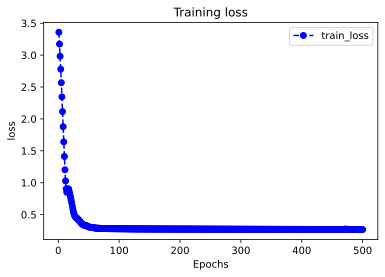

In [31]:
plot_metric(history,"loss")

![](./data/1-4-损失函数曲线.png)

### 五，使用模型

此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

In [35]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [41]:
arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))
arr_predict

array([[  11.229359, 1224.3074  ,   14.122997]], dtype=float32)

![](./data/1-4-日期3月10.png)

In [42]:
#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [43]:
dfresult.query("confirmed_num==0").head()

# 第55天开始新增确诊降为0，第45天对应3月10日，也就是10天后，即预计3月20日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
50,0.0,943.0,5.0
51,0.0,879.0,4.0
52,0.0,819.0,3.0
53,0.0,762.0,2.0
54,0.0,709.0,1.0


![](./data/1-4-预测确诊.png)

In [44]:
dfresult.query("cured_num==0").head()

# 第164天开始新增治愈降为0，第45天对应3月10日，也就是大概4个月后，即7月10日左右全部治愈。
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数。

,confirmed_num,cured_num,dead_num
115,0.0,0.0,0.0
116,0.0,0.0,0.0
117,0.0,0.0,0.0
118,0.0,0.0,0.0
119,0.0,0.0,0.0


![](./data/1-4-预测治愈.png)

In [45]:
dfresult.query("dead_num==0").head()

# 第60天开始，新增死亡降为0，第45天对应3月10日，也就是大概15天后，即20200325
# 该预测较为合理

,confirmed_num,cured_num,dead_num
55,0.0,659.0,0.0
56,0.0,612.0,0.0
57,0.0,569.0,0.0
58,0.0,529.0,0.0
59,0.0,491.0,0.0


![](./data/1-4-预测死亡.png)

### 六，保存模型

推荐使用TensorFlow原生方式保存模型。

In [ ]:
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"Python与算法之美"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![image.png](./data/Python与算法之美logo.jpg)